# Proyecto 03 - Sistema de recomendación de videojuegos en Steam

El objetivo del proyecto es crear un sistema de recomendación de videojuegos para la plataforma Steam, esto a partir de las reviews de los usuarios y los datos de los videojuegos.

## 0. Librerias y conformación de los datasets

In [1]:
# Importamos la librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para optimizar el uso de la RAM
import gzip
import gc #garbage collector

# Librerías para la predicción - Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV


from collections import defaultdict
from surprise import Dataset
import random
from icecream import ic

In [2]:
# Definimos una función para leer cada linea de los datos comprimidos
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
# Importar los datos de las caracteristicas de los juegos

# Funcion para coger solo una cantidad de datos en orden
data_games = []
num = 100000000
for i, l in enumerate(parse(r'datos/steam_games.json.gz')):
    data_games.append(l)
    if i == num:
        break


In [4]:
# Importar los datos de las reviews

# Funcion para coger solo una cantidad de datos en orden
data_reviews = []
num = 100000
for i, l in enumerate(parse('datos/steam_reviews.json.gz')):
    data_reviews.append(l)
    if i == num:
        break
        
# Funcion para guardar cada n datos
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 10000000
#for l in parse(r'datos/steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1

In [5]:
# Crear un data frame con los datos
df_games = pd.DataFrame(data_games)
df_rev = pd.DataFrame(data_reviews)

In [6]:
# Revisamos el dataset de reviews
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Notamos que el dataset contiene las siguientes columnas:

* username: Nombre del usuario que realiza la review
* hours: Número de horas que pasó jugando el juego hasta el momento de la review
* products: Cantidad de productos adquiridos por el usuario
* product_id: Código del producto al que le corresponde la review
* page_order: 
* date: Fecha de la reseña
* text: Texto de la reseña
* early_acces: Indica si el usuario recibió acceso temprano al juego o no
* page: página donde se encuentra la reseña
* found_funny: Cantidad de personas que marcaron la reseña como "divertida"
* compensation: Si el juego fue recibido de forma gratuita o no
* user_id: Código de identificación para el usuario

Vamos a limpiar un poco el dataset quitando las columnas que no nos interesan

In [7]:
df_rev = df_rev.drop(columns=['page_order','early_access','page','found_funny','compensation', 'date', 'text'])

También eliminamos aquellas isntancias que se encuentran repetidas en el dataset

In [8]:
# Eliminamos filas duplicadas
df_rev = df_rev.drop_duplicates()

A continuación, vamos a agregar datos de algunos usuarios externos a los que se encuentran en el dataset con el fin de verificar el sistema de recomendaciones al finalizar la implementación

In [9]:
## diccionario de usuario
dict_user = ['Andres Velasquez',{
                            236850:20,
                            252950:10,
                            281990:20,
                            202970:30,
                            254300:40,
                            8930:5,
                            620:10,
                            113200:10
                                }
            ]
dict_user2 = [
    'Mauricio Perea', {
        236850:80,
        394360:21,
        8930:11
#  hearts of iron 394360
# 8930    civilization
    }
]
df_rev

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075
...,...,...,...,...,...
99993,apotterx1,1.3,11.0,461560,NaN
99994,Gargoylenbe ✌,0.6,259.0,461560,NaN
99995,edvineriS,0.9,34.0,461560,76561198215396451
99999,MeltDown,1.3,223.0,233270,NaN


In [10]:
dict_user[0]

'Andres Velasquez'

In [11]:
### esta funcion mete los juegos al dataset
dfrev2 = df_rev.copy()

username = dict_user[0]
for id_game, hours in dict_user[1].items():
    dic_tool = {
        'username': username,
        'hours': hours,
        'product_id': str(id_game),
        'products': 8,
        'user_id': 1
    }
    dfrev2 = dfrev2.append(dic_tool, ignore_index=True)
    
username2 = dict_user2[0]
for id_game2, hours2 in dict_user2[1].items():
    dic_tool2 = {
        'username': username2,
        'hours': hours2,
        'product_id': str(id_game2),
        'products': 8,
        'user_id': 2
    }
    dfrev2 = dfrev2.append(dic_tool2, ignore_index=True)

dfrev2.tail(20)
df_rev = dfrev2.copy()
df_rev.tail(15)

,username,hours,products,product_id,user_id
96917,Gargoylenbe ✌,0.6,259.0,461560,NaN
96918,edvineriS,0.9,34.0,461560,76561198215396451
96919,MeltDown,1.3,223.0,233270,NaN
96920,Generalis,7.9,255.0,233270,NaN
96921,Andres Velasquez,20.0,8.0,236850,1
96922,Andres Velasquez,10.0,8.0,252950,1
96923,Andres Velasquez,20.0,8.0,281990,1
96924,Andres Velasquez,30.0,8.0,202970,1
96925,Andres Velasquez,40.0,8.0,254300,1
96926,Andres Velasquez,5.0,8.0,8930,1


In [12]:
df_rev

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075
...,...,...,...,...,...
96927,Andres Velasquez,10.0,8.0,620,1
96928,Andres Velasquez,10.0,8.0,113200,1
96929,Mauricio Perea,80.0,8.0,236850,2
96930,Mauricio Perea,21.0,8.0,394360,2


Luego, veamos las medidas estadísticas que podemos obtener del dataset

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


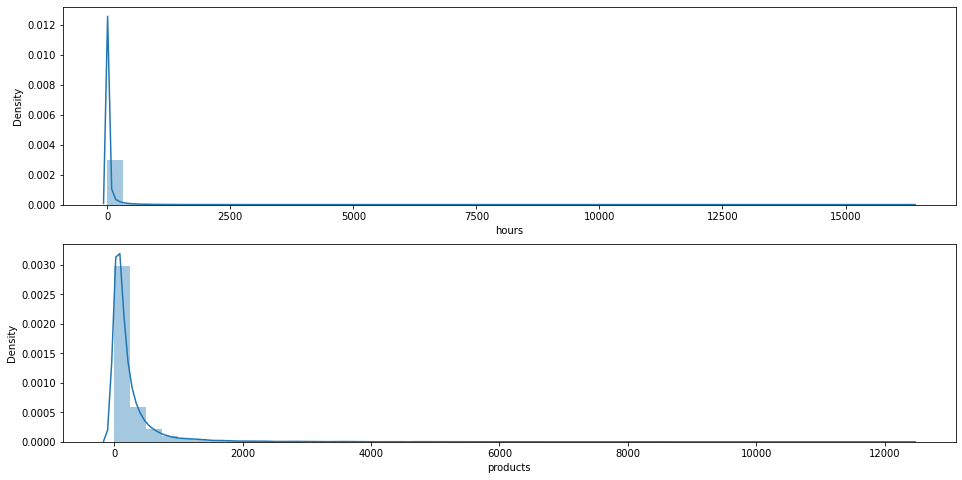

In [13]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])
plt.show()

No es posible apreciar de manera adecuada una distribución de las variables debido a la gran cantidad de datos extremos que tiene en su cola derecha, por lo cual vamos a hacer una limpieza de esta cola con ayuda del rango intercuartílico

In [14]:
# Definimos las columnas sobre las cuales haremos la limpieza
cols_df_rev = ['hours', 'products']

for a in range(len(cols_df_rev)):
    # Determinamos el cuartil 25
    Q1 = df_rev[cols_df_rev[a]].quantile(0.25)
    # Determinamos el cuartil 75
    Q3 = df_rev[cols_df_rev[a]].quantile(0.75)
    # Determinamos el rango intercuartil
    IQR = Q3 - Q1
    # Filtramos los valores
    filter = (df_rev[cols_df_rev[a]] <= Q3 + 3 * IQR)
    df_rev = df_rev.loc[filter]

# Muestra las dimensiones del nuevo dataset
print(df_rev.shape)

(82646, 5)


/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


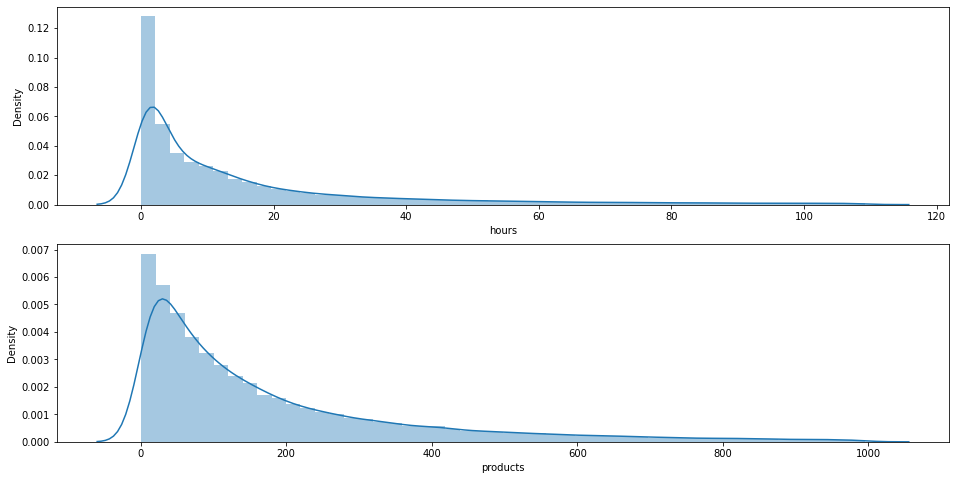

In [15]:
# Obtenemos las distribuciones de las variables a analizar 

fig, axes = plt.subplots(2, 1, figsize=(16,8))

sns.distplot(df_rev['hours'], ax = axes[0])
sns.distplot(df_rev['products'], ax = axes[1])
plt.show()

Aquí podemos observar claramente que tiene la forma de una ley de potencias, donde la mayor cantidad de datos se concentran en menor cantidad de productos y de horas jugadas.

In [16]:
df_rev.describe()

,hours,products
count,82646.000000,82646.000000
mean,15.654015,177.585642
std,21.210657,194.659161
min,0.000000,1.000000
25%,1.800000,40.000000
50%,7.300000,106.000000
75%,19.800000,242.000000
max,109.200000,995.000000


Ahora miraremos los datos faltantes de cada columna

In [17]:
from prettytable import PrettyTable

valNan = PrettyTable()

valNan.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_rev)):
    valNan1 = df_rev[cols_df_rev[a]].isna().sum()
    valNan.add_row([cols_df_rev[a],valNan1])

print(valNan)

+----------+---------------------+
| Columna  | # Valores faltantes |
+----------+---------------------+
|  hours   |          0          |
| products |          0          |
+----------+---------------------+


Para continuar con el análisis, haremos el mismo análisis para el dataset con la información de los juegos para luego relacionarlos

In [18]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


Las columnas del dataset son:

* <b>publisher:</b> Contiene el nombre del editor 
* <b>genres:</b> Contiene información sobre los géneros que están asociados
* <b>app_name:</b> El nombre 
* <b>title:</b> El título
* <b>url:</b> Dirección web donde se encuentra
* <b>release_date:</b> Fecha de lanzamiento
* <b>tags:</b> Etiquetas colocadas para encontrar el juego
* <b>discount_price:</b> Precio con descuento
* <b>reviews_url:</b> Dirección web de las reseñas
* <b>specs:</b> Especificaciones del juego
* <b>price:</b> Precio full
* <b>early_access:</b> Si el juego tuvo "acceso anticipado" o no
* <b>id:</b> Código de identificación del juego
* <b>developer:</b> Contiene el nombre del desarrollador
* <b>sentiment:</b>
* <b>metascore:</b> 

Antes de eliminar las columnas que no son relevantes del dataset, vamos a ver los datos faltantes y así determinar qué columnas dejar o borrar, debido a que columnas como `"app_names"` y `"title"` parecen contener la misma información, al igual que `"publisher"` y `"developer"`

In [19]:
cols_df_games = list(df_games.columns)
valNan2 = PrettyTable()

valNan2.field_names = ['Columna','# Valores faltantes']

for a in range(len(cols_df_games)):
    valNan3 = df_games[cols_df_games[a]].isna().sum()
    valNan2.add_row([cols_df_games[a],valNan3])

print(valNan2)

+----------------+---------------------+
|    Columna     | # Valores faltantes |
+----------------+---------------------+
|   publisher    |         8052        |
|     genres     |         3283        |
|    app_name    |          2          |
|     title      |         2050        |
|      url       |          0          |
|  release_date  |         2067        |
|      tags      |         163         |
| discount_price |        31910        |
|  reviews_url   |          2          |
|     specs      |         670         |
|     price      |         1377        |
|  early_access  |          0          |
|       id       |          2          |
|   developer    |         3299        |
|   sentiment    |         7182        |
|   metascore    |        29458        |
+----------------+---------------------+


Eliminamos las columnas que no son relevantes para el fin de este proyecto

In [20]:
# Eliminamos las columnas que no son relevantes
df_games = df_games.drop(columns=['publisher', 'title', 'url', 'release_date', 'discount_price', 'reviews_url', 'specs',
                                  'price', 'early_access', 'sentiment', 'metascore', 'genres'])

In [21]:
# Eliminamos las instancias sin valor de 'id' y de 'app_name'

df_games = df_games.dropna(subset=['id', 'app_name'])

In [22]:
df_games

,app_name,tags,id,developer
0,Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",761140,Kotoshiro
1,Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...",643980,Secret Level SRL
2,Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...",670290,Poolians.com
3,弹炸人2222,"[Action, Adventure, Casual]",767400,彼岸领域
4,Log Challenge,"[Action, Indie, Casual, Sports]",773570,NaN
...,...,...,...,...
32130,Colony On Mars,"[Strategy, Indie, Casual, Simulation]",773640,"Nikita ""Ghost_RUS"""
32131,LOGistICAL: South Africa,"[Strategy, Indie, Casual]",733530,Sacada
32132,Russian Roads,"[Indie, Simulation, Racing]",610660,Laush Dmitriy Sergeevich
32133,EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",658870,"xropi,stev3ns"


Ahora, vamos a juntar ambos datasets

In [23]:
df_games = df_games.rename(columns={"id": "product_id"})

In [24]:
df_steam = df_rev.merge(df_games, on="product_id")

In [25]:
## encodeamos el username para tener ids en numeros.
from sklearn.preprocessing import OrdinalEncoder
array = df_steam.username.astype(str)
oe = OrdinalEncoder()
users = oe.fit_transform(np.asarray(array).reshape(-1, 1))
users = users.astype(int)

df_steam.insert(0,'userid', users)

## borramos las ids viejas
df_steam.drop(columns=['user_id'], inplace=True)

In [26]:
df_steam

,userid,username,hours,products,product_id,app_name,tags,developer
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
1,46507,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
2,43548,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
3,70404,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin
4,72314,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,Gunspell - Steam Edition,"[Adventure, RPG, Indie, Puzzle, Match 3]",Ino-Co Plus
...,...,...,...,...,...,...,...,...
82641,3119,Andres Velasquez,5.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)"
82642,29852,Mauricio Perea,11.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)"
82643,3119,Andres Velasquez,10.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve
82644,3119,Andres Velasquez,10.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl


In [27]:
df_steam.isna().sum()

userid         0
username       0
hours          0
products       0
product_id     0
app_name       0
tags           0
developer     64
dtype: int64

In [28]:
df_steam_nd = df_steam[df_steam['developer'].isna() == True]['app_name'].value_counts()
df_steam_nd

Steam Dev Days                                   20
Streamer Simulator                               14
Creature Factory 2                                7
In The Shadow                                     6
Hit & Run                                         6
Gamer                                             3
Poco's Udon World                                 3
Robotpencil Presents: Improving Your Line Art     2
After Dark Original: Area 51                      1
Galapagos Evolution                               1
The Haunting in Connecticut                       1
Name: app_name, dtype: int64

Notamos que uno de los "juegos" al que le falta el valor de desarrollador se llama "Steam Dev Days", el cual es en realidad una conferencia que realiza la compañía y no un juego como tal, por lo tanto lo más recomendable sería hacer una categorización por géneros que no tengan etiquetas relacionadas a estos, tales como "documentary"

Siguiendo con el análisis, vamos a eliminar aquellas instancias con datos faltantes debido a que no son una porción representativa de nuestro total de datos

In [29]:
df_steam = df_steam.dropna()

In [30]:
df_steam.isna().sum()

userid        0
username      0
hours         0
products      0
product_id    0
app_name      0
tags          0
developer     0
dtype: int64

Ahora, teniendo el dataset entre usuarios y juegos relacionados, podemos responder varias preguntas, entre ellas:

* ¿Cuáles son los juegos más jugados?
* ¿Los usuarios que más productos tienen también son los que más horas jugadas tienen?
* Para los usuarios que más horas jugadas tienen ¿Qué juegos tienen en común?
* ¿Cuáles son los géneros de juegos que más se compran según el dataset?

### Los juegos con más horas jugadas

In [31]:
# Primero dejamos por fuera los datos ingresados en un inicio para probar el modelo
df_steam2 = df_steam[~((df_steam['username']==dict_user[0]) | (df_steam['username']==dict_user2[0]))]

# Agrupamos el dataset por los juegos y sumamos los valores de las horas jugadas
df_top_games = df_steam2.groupby('app_name')['hours'].sum()
df_top_games

app_name
A Room Beyond                             33.2
A Timely Intervention                     46.1
A Valley Without Wind                   3226.1
Abscond                                    2.7
Action Henk                             3002.4
                                         ...  
[the Sequence]                           492.8
fault - milestone one                   6135.7
interLOGIC                                28.0
rFactor                                 2857.2
東方天空璋 ～ Hidden Star in Four Seasons.    3475.6
Name: hours, Length: 311, dtype: float64

Nos parece importante tener en cuenta la cantidad de jugadores de cada juego, pues es un factor que influencia las métricas que se encontrarán

In [32]:
# Encontramos los valores únicos de los códigos de los usuarios, pues puede que hayan realizado más de un review 
df_steam_jugadores = df_steam2.groupby('app_name')['userid'].unique()

# Creamos una lista vacía que va a albergar la cantidad de jugadores
df_jugadores = []

# Contamos la cantidad de jugadores de cada juego y lo añadimos a la lista correspondiente
for a in range(df_steam_jugadores.size):
    df_jugadores.append(len(df_steam_jugadores[a]))

In [33]:
# Convertimos la variable Series a un DataFrame para así poder añadirle la cantidad de jugadores
df_top_games = df_top_games.to_frame()

In [34]:
# Añadimos la cantidad de jugadores al dataframe
df_top_games['players'] = df_jugadores
df_top_games

,hours,players
app_name,,
A Room Beyond,33.2,4
A Timely Intervention,46.1,5
A Valley Without Wind,3226.1,231
Abscond,2.7,2
Action Henk,3002.4,290
...,...,...
[the Sequence],492.8,55
fault - milestone one,6135.7,670
interLOGIC,28.0,11


In [35]:
# Obtenemos los 5 juegos con más horas jugadas en el dataset
df_top_games = df_top_games.sort_values(ascending = False, by = 'hours').head(5)

# Creamos la tabla para presentarlos
top_games_max = PrettyTable()

# Nombres de las columnas de las tablas
top_games_max.field_names = ['Juego', 'No. Horas jugadas', 'No. de jugadores']

for a in range(5):
    top_n1 = df_top_games.index[a]
    top_games_max.add_row([top_n1, round(df_top_games['hours'][a]), df_top_games['players'][a]])

print(top_games_max)

+------------------------------------------------+-------------------+------------------+
|                     Juego                      | No. Horas jugadas | No. de jugadores |
+------------------------------------------------+-------------------+------------------+
|               Grand Theft Auto V               |       178612      |       3958       |
| Batman: Arkham Asylum Game of the Year Edition |       139696      |       7202       |
|                   Brawlhalla                   |       109696      |       4349       |
|               Mark of the Ninja                |       75215       |       4127       |
|                  LawBreakers                   |       63132       |       3824       |
+------------------------------------------------+-------------------+------------------+


Habiendo hecho esto, nos surge la duda de si los juegos con más horas jugadas son los mismos con mayores horas jugadas en promedio, por lo que vamos a determinarlo

In [36]:
# Agrupamos el dataset por los juegos y hallamos el promedio de horas jugadas
df_top_games_mean = df_steam2.groupby('app_name')['hours'].mean()
df_top_games_mean

app_name
A Room Beyond                            8.300000
A Timely Intervention                    9.220000
A Valley Without Wind                   13.965801
Abscond                                  1.350000
Action Henk                             10.353103
                                          ...    
[the Sequence]                           8.960000
fault - milestone one                    9.130506
interLOGIC                               2.545455
rFactor                                 21.645455
東方天空璋 ～ Hidden Star in Four Seasons.     5.118704
Name: hours, Length: 311, dtype: float64

In [37]:
# Convertimos el objeto "Series" a "DataFrame" para poder agregar la cantidad de jugadores
df_top_games_mean = df_top_games_mean.to_frame()

In [38]:
# Agrego la columna de jugadores
df_top_games_mean['players'] = df_jugadores
df_top_games_mean

,hours,players
app_name,,
A Room Beyond,8.300000,4
A Timely Intervention,9.220000,5
A Valley Without Wind,13.965801,231
Abscond,1.350000,2
Action Henk,10.353103,290
...,...,...
[the Sequence],8.960000,55
fault - milestone one,9.130506,670
interLOGIC,2.545455,11


In [39]:
# Ordenamos el dataset según los juegos más jugados en promedio
df_top_games_mean = df_top_games_mean.sort_values(ascending=False, by='hours')

In [40]:
top_games_mean = PrettyTable()

top_games_mean.field_names = ['Juego', 'Promedio de horas jugadas', 'No. de jugadores']

for a in range(5):
    top_n1 = df_top_games_mean.index[a]
    top_games_mean.add_row([top_n1, round(df_top_games_mean['hours'][a]),df_top_games_mean['players'][a]])

print(top_games_mean)


+-------------------------+---------------------------+------------------+
|          Juego          | Promedio de horas jugadas | No. de jugadores |
+-------------------------+---------------------------+------------------+
|    Grand Theft Auto V   |             45            |       3958       |
|   Dragon Age: Origins   |             42            |       564        |
|         Gnomoria        |             36            |       617        |
| Space Empires IV Deluxe |             35            |        77        |
|     Roads of Rome 3     |             35            |        4         |
+-------------------------+---------------------------+------------------+


Notamos que si bien hay coincidencias en juegos como "Grand Theft Auto V" y "Time Clickers", el promedio de estos está considerablemente por debajo de juegos como "Fron Office Football Seven", el cual tiene un promedio muy por encima del resto de juegos. Sin embargo, también notamos que este juego con el mayor promedio también tiene un cantidad de jugadores mucho menor que otros juegos como "Grand Theft Auto V"

Luego de haber notado lo anterior, nos surge una duda ¿Qué es más representativo frente a la calidad de un juego: Las horas jugadas en total o el promedio de las mismas?

## Correlación entre cantidad de productos y horas jugadas

In [41]:
# Agrupamos el dataset por cada usuario y sumamos la cantidad de horas y productos que tiene dicho usuario
df_products = df_steam2.groupby('username').sum().drop(columns=['userid'])
df_products

,hours,products
username,,
! DeadlyDeal !,2.5,406.0
! Taz the Husky,24.8,402.0
!!!-One_shot=One_kill-!!!,1.6,10.0
!?,7.5,121.0
!@#Patrick!@#,2.8,19.0
...,...,...
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡baphoyetz,17.3,39.0
󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡󠀡,49.9,414.0
󠁿󠁿 󠁿󠁿 󠁿󠁿 󠁿,23.9,93.0


In [42]:
# Hallamos la correlación entre horas y productos
df_products.corr()

,hours,products
hours,1.000000,0.102122
products,0.102122,1.000000


Hallando una correlación entre ambas variables no da una buena correlación, pero también debemos tener en cuenta que el dataset tiene mucho ruido, entonces vamos a mirarlo manualmente con los 5 usuarios con más productos

In [43]:
# Hallamos los usuarios que más productos tienen
df_products.sort_values(by='products', ascending=False).head(5)

,hours,products
username,,
Mr. Matt,246.7,13650.0
STEVEN AGEVER,27.3,10440.0
Apparently Kid,142.8,8616.0
Beridok,36.5,8370.0
Wungle,55.8,7404.0


In [44]:
# Hallamos los usuarios que más horas jugadas tienen
df_products.sort_values(by='hours', ascending=False).head(5)

,hours,products
username,,
Ghost,417.9,1044.0
Dave,405.5,2257.0
John,393.7,3576.0
123,359.1,1107.0
Jesus,328.8,961.0


### Géneros más jugados

In [45]:
# Eliminamos los duplicados de las reviews hechas para que solo quede la última hecha por cada usuario
df_steam21 = df_steam2.drop_duplicates(subset=['username','app_name'])

In [246]:
# Desagrupamos la lista de tags y creamos nuevas filas por cada tag diferente para poder hacer un conteo
df_steam_tags = df_steam21.explode('tags')

,userid,username,hours,products,product_id,app_name,tags,developer
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,Action,Vyacheslav Shilikhin
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,Adventure,Vyacheslav Shilikhin
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,Indie,Vyacheslav Shilikhin
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,Simulation,Vyacheslav Shilikhin
1,46507,Teef 🐏,0.9,923.0,725280,Psi Project,Action,Vyacheslav Shilikhin
...,...,...,...,...,...,...,...,...
82634,20954,HotshotX86,0.2,19.0,296930,Ascendant,RPG,Hapa Games
82634,20954,HotshotX86,0.2,19.0,296930,Ascendant,Rogue-like,Hapa Games
82634,20954,HotshotX86,0.2,19.0,296930,Ascendant,Local Co-Op,Hapa Games
82634,20954,HotshotX86,0.2,19.0,296930,Ascendant,Singleplayer,Hapa Games


In [47]:
# Hacemos un conteo de datos por cada tag en el dataset
df_steam_tags.groupby(['tags'])['products'].count().sort_values(ascending=False)

tags
Singleplayer          67600
Action                64078
Adventure             57948
Indie                 50534
Atmospheric           43008
                      ...  
Trains                    9
Swordplay                 5
Sailing                   2
Silent Protagonist        1
Music                     1
Name: products, Length: 254, dtype: int64

### Juegos de las personas con mayor horas de juego

In [48]:
# Determinamos los 25 usuarios con mayor cantidad de horas jugadas
df_products2 = df_steam2.groupby('userid').sum()
top_players = list(df_products2.sort_values(by='hours', ascending=False).head(5).index)

In [49]:
# Agrupamos, por cada juego, los id's de los usuarios de dicho juego
games_players = df_steam2.groupby('app_name')['userid'].unique()
games_players

app_name
A Room Beyond                                                [25501, 42344, 35852, 46459]
A Timely Intervention                                 [60471, 66067, 70726, 42665, 23008]
A Valley Without Wind                   [56888, 20003, 54777, 67600, 58335, 26331, 584...
Abscond                                                                    [37827, 16321]
Action Henk                             [56273, 55338, 45630, 12632, 12131, 30367, 434...
                                                              ...                        
[the Sequence]                          [53668, 62465, 57932, 37399, 56975, 56909, 658...
fault - milestone one                   [36089, 20178, 375, 27152, 28571, 11418, 70190...
interLOGIC                              [62599, 25703, 68616, 53365, 60175, 63013, 233...
rFactor                                 [54166, 19723, 45644, 16486, 46823, 20428, 561...
東方天空璋 ～ Hidden Star in Four Seasons.    [20830, 73480, 42005, 32123, 37197, 11140, 405...
N

In [50]:
# Creo una lista para almacenar los juegos que se repiten
games = []

# Ciclo para determinar si los jugadores se encuentran dentro de la lista de cada juego
for a in range (len(games_players)):
    if any(x in top_players for x in games_players[a]):
        games.append(games_players.index[a])
    else:
        pass

In [51]:
games_repeat = PrettyTable()

games_repeat.field_names = ['Juego']

for a in range(len(games)):
    games_repeat.add_row([games[a]])

print(games_repeat)

+------------------------------------------------+
|                     Juego                      |
+------------------------------------------------+
|             A Valley Without Wind              |
|                 Among Ripples                  |
|  Arsenal of Democracy: A Hearts of Iron Game   |
|               Ballistic Overkill               |
| Batman: Arkham Asylum Game of the Year Edition |
|                   Brawlhalla                   |
|            Deus Ex: Mankind Divided            |
|                      EDGE                      |
|             FINAL FANTASY® XIII-2              |
|            Far Cry 3 - Blood Dragon            |
|                    Gnomoria                    |
|                Grand Ages: Rome                |
|               Grand Theft Auto V               |
|        Grandia® II Anniversary Edition         |
|               Heroes & Generals                |
|                  LawBreakers                   |
|               Mark of the Nin

Como era de esperarse, muchos de los juegos aquí encontrados son también los que se encuentran junto con horas más jugadas

# Preparación del dataset para el sistema de recomendación

Primero vamos a hallar el promedio de horas jugadas de cada juego, con este dato podemos ver que tanto se desvia un jugador del promedio de juego, esta desviacion la usaremos (despues de transfromarla y escalarla) como el rating que un usuario le da a un juego.

In [52]:
# Hallamos el promedio de horas jugadas para cada juego
df_mean = df_steam.groupby('app_name').mean()
df_mean.drop(columns=['userid', 'products'], inplace=True)
df_mean = df_mean.rename(columns={'hours':'mean_hours'})
df_mean

,mean_hours
app_name,
A Room Beyond,8.300000
A Timely Intervention,9.220000
A Valley Without Wind,13.965801
Abscond,1.350000
Action Henk,10.353103
...,...
[the Sequence],8.960000
fault - milestone one,9.130506
interLOGIC,2.545455


In [53]:
# Añadimos la columna de horas jugadas en promedio al dataframe
df_steam2 = df_steam.merge(df_mean, on='app_name')
df_steam2

,userid,username,hours,products,product_id,app_name,tags,developer,mean_hours
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000
1,46507,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000
2,43548,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000
3,70404,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000
4,72314,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,Gunspell - Steam Edition,"[Adventure, RPG, Indie, Puzzle, Match 3]",Ino-Co Plus,13.536842
...,...,...,...,...,...,...,...,...,...
82577,3119,Andres Velasquez,5.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",8.000000
82578,29852,Mauricio Perea,11.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",8.000000
82579,3119,Andres Velasquez,10.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve,10.000000
82580,3119,Andres Velasquez,10.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl,10.000000


In [54]:
# Hallamos la relación entre las horas jugadas de cada jugador con el promedio general del juego en la columna 'hours_percent'
df_steam2['hours_percent'] = ((df_steam2.hours) * 100) / df_steam2.mean_hours
df_steam3 = df_steam2.copy()
df_steam3

,userid,username,hours,products,product_id,app_name,tags,developer,mean_hours,hours_percent
0,8555,Chaos Syren,0.1,41.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000,21.052632
1,46507,Teef 🐏,0.9,923.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000,189.473684
2,43548,Sneaky_Panda,0.6,243.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000,126.315789
3,70404,wasp99rock,0.3,48.0,725280,Psi Project,"[Action, Adventure, Indie, Simulation]",Vyacheslav Shilikhin,0.475000,63.157895
4,72314,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,Gunspell - Steam Edition,"[Adventure, RPG, Indie, Puzzle, Match 3]",Ino-Co Plus,13.536842,377.488336
...,...,...,...,...,...,...,...,...,...,...
82577,3119,Andres Velasquez,5.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",8.000000,62.500000
82578,29852,Mauricio Perea,11.0,8.0,8930,Sid Meier's Civilization® V,"[Turn-Based Strategy, Strategy, Turn-Based, Mu...","Firaxis Games,Aspyr (Mac, Linux)",8.000000,137.500000
82579,3119,Andres Velasquez,10.0,8.0,620,Portal 2,"[Puzzle, Co-op, First-Person, Sci-fi, Comedy, ...",Valve,10.000000,100.000000
82580,3119,Andres Velasquez,10.0,8.0,113200,The Binding of Isaac,"[Rogue-like, Indie, Replay Value, Difficult, P...",Edmund McMillen and Florian Himsl,10.000000,100.000000


Eliminamos a las reviews que tengan 0 horas jugadas, pues no da una buena señal de la confiabilidad de su review, por que son pocos, y por que limita el encoding que queremos hacer

In [55]:
print(df_steam3[~(df_steam3['hours']<0.1)].size - df_steam3.size)
df_steam3 = df_steam3[~(df_steam3['hours']<0.1)]

-530


In [56]:
df_steam3['hours'].value_counts().sort_values()

85.5        1
106.9       2
89.5        2
106.8       3
99.6        3
         ... 
0.5      1519
0.4      1582
0.3      1815
0.1      2318
0.2      2384
Name: hours, Length: 1092, dtype: int64

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours', ylabel='Density'>

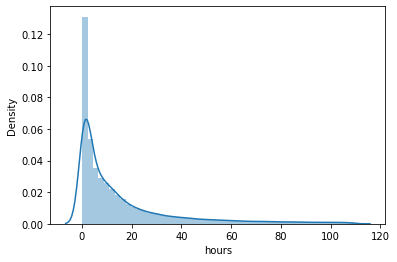

In [57]:
# Volvemos a graficar la distribución de las horas jugadas para ver el cambio
sns.distplot(df_steam3['hours'])

# COMENTAR CAMBIOS FRENTE A LA GRÁFICA SIN ENCODING

Lo que tenemos aqui es una distribucion de 'power law' o 'right skewed' que vamos a encodear primero sacandole su logaritmo para hacerla mas parecida a una distribucion gausiana y despues la encodeamos con las herramientas de sklearn.

In [58]:
# Hallamos el logaritmo del porcentaje de horas jugadas para cada jugador
df_steam3['log_hours'] = np.log(df_steam3.hours_percent)

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_hours', ylabel='Density'>

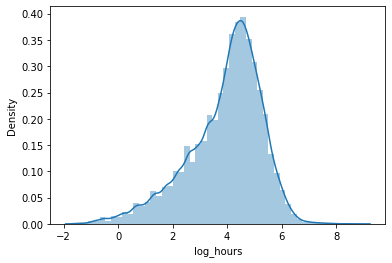

In [59]:
# Verificamos el escalado graficando la distribución logarítmica
sns.distplot(df_steam3['log_hours'])

A continuación, utilizaremos la herramientas de escalado de SkLearn para que los valores de horas jugadas se encuentren entre 1 y 10, un formato más adecuado para un sistema de recomendación

In [60]:
# Hacemos un escalado con sklearn con valores entre 1 y 10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,10))
dataset = scaler.fit_transform(np.asarray(df_steam3.log_hours).reshape(-1, 1))
df_steam3['escalados'] = dataset

/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/andres/anaconda3/envs/data/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='escalados', ylabel='Density'>

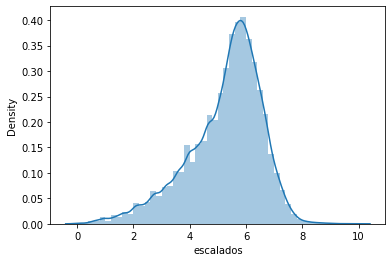

In [61]:
# Distribución final de los datos escalados
sns.distplot(df_steam3['escalados'])

# Modelo de sistema de recomendacion

In [62]:
#### Preparacion del dataset objeto de Surprise
### Orden de las features
# columnas user; item; rating; timestamp
# dataset  username; product_id; escalado; date
df_reader = df_steam3[['userid', 'product_id', 'escalados']] #date lacking
## crear una copia del dataset por seguridad
df_reader_og = df_steam3[['userid', 'product_id', 'escalados', 'username']]
df_reader

,userid,product_id,escalados
0,8555,725280,4.407614
1,46507,725280,6.536133
2,43548,725280,6.143346
3,70404,725280,5.471873
4,72314,328100,7.203869
...,...,...,...
82577,3119,8930,5.461729
82578,29852,8930,6.225532
82579,3119,620,5.917036
82580,3119,113200,5.917036


In [63]:
## Creacion objeto reader y el dataset 
reader = Reader(rating_scale=(1,10), line_format='user item rating')
data = Dataset.load_from_df(df_reader, reader=reader)

In [64]:
## Separar sets de entrenamiento y testeo
trainset, testset = train_test_split(data, test_size=.25)

# Eleccion y optimizacion del modelo

In [65]:
from surprise import SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

benchmark = []
algorits = [SlopeOne(), BaselineOnly(), SVDpp(), SVD(), NormalPredictor()] # KNNWithMeans(), BaselineOnly() #SVDpp(), SlopeOne(), NMF()
# Iterate over all algorithms
for algorithm in algorits:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.288165,0.367359,0.195497
SVD,1.293638,4.625455,0.200196
SVDpp,1.303544,8.228394,0.364465
SlopeOne,1.381561,0.899044,0.324937
NormalPredictor,1.858343,0.106631,0.268392


In [66]:
## optimizacion con gridsearch svd
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
gs.best_score['rmse'], gs.best_params, gs.best_estimator

(1.2900866983790573,
 {'rmse': {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4},
  'mae': {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}},
 {'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f607bb54d50>,
  'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x7f607b911050>})

In [67]:
### Testear el algoritmo optimizado en el dataset
algo = gs.best_estimator['rmse']
resultados = pd.DataFrame(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True))
#resultados

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2947  1.2882  1.2874  1.2933  1.2838  1.2895  0.0040  
MAE (testset)     0.9950  0.9930  0.9859  0.9930  0.9891  0.9912  0.0033  
Fit time          2.41    2.52    2.48    2.53    2.50    2.49    0.04    
Test time         0.11    0.13    0.12    0.11    0.11    0.12    0.01    


In [99]:
## funcion para traducir los resultados de la funcion 'predecir()'
def traducir(preds):
    rows_list = []
    ## coger el username por medio de los indices
    for user in preds:
        index_user = df_reader.loc[df_reader.userid == user].index[0]
        username = df_reader_og[df_reader_og.index == index_user].username.values[0]
    ## coger el titulo del juego y el rating
        revs = preds[user]
        for game_id, score in revs:
            game_name = df_games.loc[df_games.product_id == game_id].app_name.values[0]
            ## transformar el score a horas
            hours = np.exp(score)
            ## anadirlo al data frame
            dict = {
                'username':username,
                'game_id':game_name,
                'expected_hours':hours
            }
            rows_list.append(dict)
    df = pd.DataFrame(rows_list)
    return df

In [118]:
### definir funcion para que prediga un numero de peliculas al azar
### con el dataset

def predecir(dataset,
            algo,
            n_random_games=15,
            n_random_users=50,
            top=5,
            game_ids=0,
            user_ids=0,
            predicts=10):
    '''
    Esta funcion crea un diccionario con predicciones que los usuarios no han 
        rateado.
    - num_predicts: es el numero de predicciones que hacer para cada usuario
    - user_ids: el id de las personas, si rand_users es True, no hay que poner            user_ids.
    - rand_users: si coger a usuers al azar para hacer predicciones.
    - dataset: el dataset con las predicciones con las que se entrena el modelo. en       nuestro caso "df_reader".
    - algo: el algoritmo que se va a use. En nuesto caso "algo2".
    '''
    predicted = defaultdict(list)
    ## if the input is empty or 0 get random get random items
    total_games = len(dataset.product_id.value_counts().index)
    total_users = len(dataset.userid.value_counts().index)
    if game_ids==0:
        if n_random_games > total_games:
            n_random_games = total_games
        j = dataset.product_id.value_counts().index
        game_ids=random.sample(list(j), n_random_games)
    if user_ids==0:
        if n_random_users > total_users:
            n_random_users = total_users
        u = dataset.userid.value_counts().index
        user_ids = random.sample(list(u), n_random_users)

    ### loop trough users and games and append to 'predicted'
    for user in user_ids:
        for game in game_ids:
            ## skipear si ya habia rateado el juego
            v = dataset.loc[(dataset.userid == user) & (dataset.product_id == game)]
            if len(v) == 0:
                ## predict and append the predictions
                pred = algo.predict(user, game)
                predicted[pred[0]].append((pred[1],pred[3]))

    # sort the predictions for each user
    for uid, user_ratings in predicted.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        predicted[uid] = user_ratings[:top]
    return traducir(predicted), predicted



In [101]:
# Buscar las predicciones de los usuarios que pusimos nosotros
usuario1 = df_reader[df_reader_og.username == 'Andres Velasquez'].userid.iloc[0]
usuario2 = df_reader[df_reader_og.username == 'Mauricio Perea'].userid.iloc[0]

In [432]:
## probar la funcion y coger un pequeno dataset ara traducir
df9, df9_raw = predecir(df_reader, algo, n_random_games=30000, user_ids=[usuario1, usuario2])

In [436]:
df9

,username,game_id,expected_hours
0,Andres Velasquez,Grim Legends 3: The Dark City,320.969704
1,Andres Velasquez,Batman: Arkham Asylum Game of the Year Edition,301.446844
2,Andres Velasquez,Deep Sky Derelicts,294.923412
3,Andres Velasquez,Return to Mysterious Island 2,290.464914
4,Andres Velasquez,Wooden Sen'SeY,290.086519
5,Mauricio Perea,Grim Legends 3: The Dark City,292.634639
6,Mauricio Perea,Batman: Arkham Asylum Game of the Year Edition,284.300819
7,Mauricio Perea,In Between,283.893381
8,Mauricio Perea,Bravada,275.458691
9,Mauricio Perea,Deep Sky Derelicts,274.347464


# PARTE C: INVESTIGACION

En el proyecto usamos la libreria surprise para hacer un sistema de recomendacion de tipo colaborativo. El resultado fue bueno, pero hay muchas aristas donde podriamos tal vez tener un mejor resultado.
1. Podriamos hacer un modelo de recomendacion mixto al combinar nuestro modelo de surprise con uno basado en contenido. Asi podriamos aprovechar las otras features que tiene el data set. Podriamos tambien tratar de darle mas peso al contenido mas popular o mas moderno para mejorar tal vez la satisfaccion de los usuarios.
2. En nuestro modelo utilizamos el porcentaje de desviacion de horas jugadas de los usuarios comparandolo con el promedio de cada juego. Esto lo hicimos con el objetivo de evitar que el modelo recomendara simplemente los juegos que son mas largos en su naturaleza, pero tal vez la mejor opcion seria combinar el estimador con el valor absoluto de las horas jugadas. Creo que esto es lo que se llama un estimador de James-Stein.
3. Hay otros datasets en internet de steam asi que podriamos probarlos  y analizar si los resultados mejoran y si tienen mas features, por que a este dataset le faltaba la feautre de si el usuario le daba una manito arriba o abajo al juego, una feature sumamente importante.
4. Podriamos tambien hacer una interfaz mas amable y sensilla para que los usuarios añadasn al dataset sus ratings de juegos. 
5. Como se sabe si el modelo realmente funciona para predecir que tanto le gustará a un jugador el un juego? en surprise podemos ver las metricas como rmse o mae pero este error no nos dice realmente mucho. Nosotros intentamos ver si el tags de las predicciones del modelo se parecian a los tags de las reviews que hacian los jugadores. No nos parecio muy concluyente este metodo.
6. En nuestro proyecto tenemos limites a la cantidad de datos que podemos usar para entrenar el modelo. Tal vez muchas reviews de los usuarios quedan por fuera y en el dataset actual solo se usan 2 o 3 reviews de usuarios que pordrian tener 15 reviews en promedio. Esto nos deja en una desventaja pues al ser un filtro colabortivo es muy importante que cada usuario tenga un numero considerable de reviews, pues si no tiene suficientes el sistema no podra perfilarlo junto a otra persona que haya jugado juegos similares. Talvez exista una forma de cargar mas datos del data set, y entrenar el modelo progresivamente, sin explotar el computador


In [4]:
## Creamos diccionarios donde estan las categorias jugadas por los usuarios sacadas 
    # de los juegos que jugaron y los juegos que el modelo predijo que jugaron
dict_tags = {}
for user in df9_raw:
    ## lista actual reviews
    info1 = list(df_rev[df_rev.username == 'Andres Velasquez'].product_id.value_counts().index)
    dict_tags[user] = {}
    dict_tags[user]['real'] = []   
    for game in info1:
        dict_tags[user]['real'] += df_games[df_games.product_id == str(game)].tags.value_counts().index[0]

    ## lista predicciones
    dict_tags[user]['predicted'] = []   
    for info in df9_raw[user]:
        dict_tags[user]['predicted'] += df_games[df_games.product_id == str(info[0])].tags.value_counts().index[0]

    ### create a list with the distributions
    dict_tags[user]['dist_real'] = Counter(dict_tags[user]['real'])
    dict_tags[user]['dist_predicted'] = Counter(dict_tags[user]['predicted'])

#dict_tags

NameError: name 'df9_raw' is not defined

In [3]:
##  graficar la distribucion de los generos

def graph_dist(dict):
    num_users = (len([x for x in dict]))
    

    for i, user in enumerate(dict):
        fig, ax = plt.subplots(num_users-1, 2,  sharey=True, figsize=(15,5))
        fig.suptitle(user)

        r = dict_tags[user]['dist_real'].most_common()
        for t in r:
            x = [t[0] for t in r][:15]
            y = [t[1] for t in r][:15]

        sns.countplot(ax=ax[0], x=x, y=y)
        ax[0].tick_params(labelrotation=90)
        ax[0].set_title('real genres')

        p = dict_tags[3119]['dist_predicted'].most_common()
        for n in p:
            x = [n[0] for n in p][:15]
            y = [n[1] for n in p][:15]
        sns.countplot(ax=ax[1], x=x, y=y)
        ax[1].tick_params(labelrotation=90)
        ax[1].set_title('predicted genre distribution')

graph_dist(dict_tags)


## Conclusion del analisis por categorias
Al analizar las categorias de las que hacen parte las reviews y las predicciones del modelo podemos ver que no hay mucha similitud entre las categorias. Son muy disimiles. El modelo no esta recibiendo features de las categorias pero esperabamos que tal vez el modelo, al relacionar personas con personas para poder predecir el rating (horas jugadas), relacionaria tambien categorias pues los usuarios tienden a preferir juegos de la misma categorio, generalmente.